In [1]:
#import modules

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import precision_score,recall_score,f1_score,confusion_matrix,accuracy_score
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from tqdm import tqdm

In [2]:
class SVM:
    
    def __init__(self,enzyme_datafile,random_seed=None,kmer=7,pca_comp=20,regC=1,kern='rbf',optimize=True,verbose=True):
        np.random.seed(random_seed)
        
        with open(enzyme_datafile,'r') as f:
            enzyme_names = []
            X = []
            y = []
            for lines in f:
                line  = lines.strip().split(',')
                enzyme_names.append(line[0])
                X.append(line[1])
                y.append(int(line[2]))
        
        # Storing the values obtained from the file
        self.X = np.array(X)
        self.y = np.array(y)
        self.enzyme_names = np.array(enzyme_names)
        
        # Creating train and test index, with a modified split function
        self.test_idx,self.train_idx = self._modified_split()
        
        # Creating train & test features and labels
        self.Xtrain_raw = self.X[self.train_idx]
        self.Xtest_raw = self.X[self.test_idx]
        self.ytrain = self.y[self.train_idx]
        self.ytest = self.y[self.test_idx]
        
        # Creating the feature space
        self.encoder_dict = self._Ngram_encoder_fit(self.Xtrain_raw,kmer)
        
        self.Xtrain = self._Ngram_encoder_transform(self.Xtrain_raw,kmer)
        self.Xtest = self._Ngram_encoder_transform(self.Xtest_raw,kmer)
        
        
        # Lowering the dimension of the feature space using PCA
        self.Xtrain_pca,self.Xtest_pca = self._conduct_PCA(self.Xtrain,self.Xtest,pca_comp)
        
        # Training the initial SVM model
        init_model = self._train_SVM(self.Xtrain_pca,self.ytrain,regC,kern)
        
        # print evaluation results
        self.ypredtrain = self._predict_SVM(init_model,self.Xtrain_pca)
        self.ypredtest = self._predict_SVM(init_model,self.Xtest_pca)
        self.acc_train = accuracy_score(self.ytrain,self.ypredtrain)
        self.acc_test = accuracy_score(self.ytest,self.ypredtest)
        
        if verbose:
            print('-'*5+'Initial Model Evaluation'+'-'*5)
            print('-'*5+'Training Accuracy:'+str(self.acc_train)+'-'*5)
            print('-'*5+'Testing Accuracy:'+str(self.acc_test)+'-'*5)
        
        # Hyperparameter Optimization
        
        if optimize:
            print('-'*5+'Hyperparameter Optimization'+'-'*5)
            steps = [('pca',PCA()),('SVM',SVC())]
            pipeline = Pipeline(steps)

            parameters = {'pca__n_components':[1,5,10,15,25,40],
                         'SVM__C':[0.001,0.1,10,100,10e5],
                         'SVM__gamma':['scale','auto',0.1,0.01],
                         'SVM__kernel':['linear','rbf']}

            self.grid = GridSearchCV(pipeline, param_grid=parameters, cv=5, n_jobs=-1,scoring='accuracy',verbose=2)
            self.grid.fit(self.Xtrain, self.ytrain)
            
            # print evaluation results

            print("score = %3.2f" %(self.grid.score(self.Xtest,self.ytest)))

            print(self.grid.best_params_)
            
            best_pipeline = self.grid.best_estimator_
        
        
        
    
    def _modified_split(self,split=0.25):
        r = range(len(self.enzyme_names))
        cuphea_idx = [idx for idx in r if self.enzyme_names[idx].startswith('Cuphea_viscosisssima')]
        other_idx = [idx for idx in r if idx not in cuphea_idx]
        np.random.shuffle(other_idx)
        np.random.shuffle(cuphea_idx)
        lr_other = int(split*len(other_idx))
        lr_cuphea = int(split*len(cuphea_idx))
        test_split_idx = np.append(other_idx[:lr_other],cuphea_idx[:lr_cuphea])
        train_split_idx = np.append(other_idx[lr_other:],cuphea_idx[lr_cuphea:])

        np.random.shuffle(test_split_idx)
        np.random.shuffle(train_split_idx)
        
        
        return test_split_idx,train_split_idx 
    
    
    def _Ngram_encoder_fit(self,sequences,n):
        ngramdict = dict()
        for sequence in sequences:
            i=0
            while i+n<=len(sequence):
                seq = sequence[i:i+n]

                if seq in ngramdict:
                    ngramdict[seq] += 1
                else:
                    ngramdict[seq] = 1
                i+=1
                
        feature_list = sorted([k for k,v in ngramdict.items() if v>1])
        
        return dict(zip(feature_list,list(range(len(feature_list)))))
    
    def _Ngram_encoder_transform(self,sequences,n):
        
        X_motif = []

        for sequence in sequences:
            ind_vector = np.zeros(len(self.encoder_dict))
            
            i=0
            while i+n<=len(sequence):
                seq = sequence[i:i+n]

                if seq in self.encoder_dict:
                    ind_vector[self.encoder_dict[seq]] = 1

                i+=1
                
            X_motif.append(ind_vector)
            
        return np.array(X_motif)
        
        
    def _conduct_PCA(self,X_train,X_test,n_comp):
        pca = PCA(n_comp)
        pca.fit(X_train)
        return pca.transform(X_train),pca.transform(X_test)
    
    def _train_SVM(self,X_train,y_train,c,k):
        clf = SVC(C = c,kernel=k,gamma='scale',tol=1e-6,class_weight='balanced')
        clf.fit(X_train,y_train)
        return clf
    
    def _predict_SVM(self,svm_model,X_val):
        return svm_model.predict(X_val)
        

In [3]:
file='Data/Enzyme_Dataset.txt'
model = SVM(file,random_seed=7,kmer=3,pca_comp=20,regC=1,optimize=False)

-----Initial Model Evaluation-----
-----Training Accuracy:0.7530864197530864-----
-----Testing Accuracy:0.64-----


## Model Evaluation by varying k-mer

In [4]:
kmers = [2,3,5,7,9,11,13,15,17,25,35]
accs_train = []
accs_test = []
 
for km in kmers:
    kmodel = SVM(file,random_seed=7,kmer=km,pca_comp=40,regC=10,optimize=False,verbose=False)
    accs_train.append(kmodel.acc_train)
    accs_test.append(kmodel.acc_test)

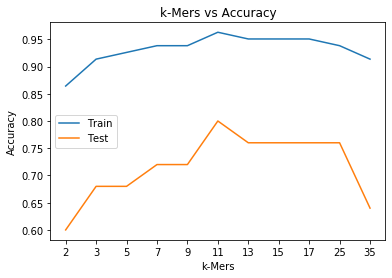

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(np.arange(len(kmers)),accs_train,label='Train')
plt.plot(np.arange(len(kmers)),accs_test,label='Test')
plt.legend()
plt.title('k-Mers vs Accuracy')
plt.xlabel('k-Mers')
plt.ylabel('Accuracy')
plt.xticks(np.arange(len(kmers)),kmers)
plt.savefig('../Images/VaryingKmer.png');

# Final Model Evaluation

In [12]:
final_model = SVM(file,random_seed=7,kmer=11,pca_comp=40,regC=10,optimize=False,verbose=False)

In [14]:
final_model.acc_train,final_model.acc_test

(0.9629629629629629, 0.8)

In [17]:
precision_score(final_model.ytrain,final_model.ypredtrain,average='weighted'),precision_score(final_model.ytest,final_model.ypredtest,average='weighted')

(0.9646090534979423, 0.837090909090909)

In [18]:
recall_score(final_model.ytrain,final_model.ypredtrain,average='weighted'),recall_score(final_model.ytest,final_model.ypredtest,average='weighted')

(0.9629629629629629, 0.8)

In [19]:
confusion_matrix(final_model.ytest,final_model.ypredtest)

array([[ 8,  0,  1],
       [ 0,  2,  0],
       [ 2,  2, 10]])

In [31]:
final_model.ypredtest

array([2, 2, 1, 1, 3, 3, 3, 1, 3, 1, 2, 3, 1, 1, 1, 3, 3, 3, 1, 1, 3, 3,
       1, 3, 2])

In [33]:
final_model.ytest

array([3, 3, 1, 1, 3, 3, 3, 1, 3, 3, 2, 3, 1, 1, 1, 3, 3, 3, 1, 1, 3, 1,
       3, 3, 2])

In [32]:
final_model.enzyme_names[final_model.test_idx]

array(['Umbellularia_californica_(UcFatB2)',
       'Cuphea_viscosisssima_(CvB2MT17)',
       'Cuphea_viscosisssima_(CvB2MT43', 'Cuphea_viscosisssima_(CvB2MT23',
       'Cuphea_viscosisssima_(CvB2MT44', 'rTE16',
       'Cuphea_viscosisssima_(CvB2MT42',
       'Cuphea_palustris(long)_(CpFatB2)',
       'Cuphea_aequipetala_(Ca1FatB2)', 'Cuphea_viscosisssima_(CvB2MT6)',
       'Elaeis_guineensis', 'rTE12', 'Cuphea_leptopoda_(Cl3FatB1)',
       'Gossypium_hirsutum', 'Cuphea_viscosisssima_(CvB2MT14', 'rTE15',
       'Cuphea_viscosisssima_(CvB2MT30', 'Cuphea_viscosisssima_(CvB2MT10',
       'Cuphea_leptopoda_(Cl1FatB1)', 'Arabidopsis_thaliana',
       'Cuphea_viscosisssima_(CvB2MT45', 'Cuphea_viscosisssima_(CvB2MT29',
       'Umbellularia_californica_(UcFatB1)',
       'Cuphea_hookeriana(short)_(ChFatB2)', 'Cinnamomum_camphorum'],
      dtype='<U34')

In [25]:
incorrectly_classified = [enz for enz,tr,pr in 
                          zip(final_model.enzyme_names[final_model.test_idx],
                              final_model.ytest,final_model.ypredtest) if tr!=pr]

In [26]:
incorrectly_classified

['Umbellularia_californica_(UcFatB2)',
 'Cuphea_viscosisssima_(CvB2MT17)',
 'Cuphea_viscosisssima_(CvB2MT6)',
 'Cuphea_viscosisssima_(CvB2MT29',
 'Umbellularia_californica_(UcFatB1)']

In [29]:
incorrectly_classified_tr = [enz for enz,tr,pr in 
                          zip(final_model.enzyme_names[final_model.train_idx],
                              final_model.ytrain,final_model.ypredtrain) if tr!=pr]

In [30]:
incorrectly_classified_tr

['Cuphea_viscosisssima_(CvFatB2',
 'Cuphea_viscosisssima_(CvB2MT11',
 'Cuphea_viscosisssima_(CvB2MT19']

# Variance in model prediction

In [6]:
train_accs= []
test_accs = []

for i in tqdm(range(10000)):
    kmodel = SVM(file,random_seed=i,kmer=11,pca_comp=40,regC=10,optimize=False,verbose=False)
    train_accs.append(kmodel.acc_train)
    test_accs.append(kmodel.acc_test) 

100%|██████████| 10000/10000 [11:04<00:00, 15.06it/s]


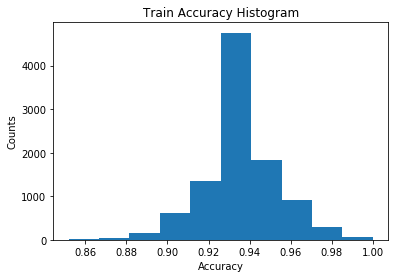

In [7]:
plt.hist(train_accs)
plt.xlabel('Accuracy')
plt.ylabel('Counts')
plt.title('Train Accuracy Histogram')
plt.savefig('../Images/ModelTrainAcc.png');

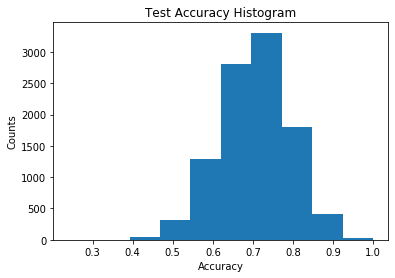

In [8]:
plt.hist(test_accs)
plt.xlabel('Accuracy')
plt.ylabel('Counts')
plt.title('Test Accuracy Histogram');
plt.savefig('../Images/ModelTestAcc.png');

In [9]:
print(f'The mean of training and testing accuracy is {np.mean(train_accs)} and {np.mean(test_accs)} respectively')

The mean of training and testing accuracy is 0.9347567901234568 and 0.709072 respectively


In [10]:
print(f'The standard deviation of training and testing accuracy is {np.std(train_accs)} and {np.std(test_accs)} respectively')

The standard deviation of training and testing accuracy is 0.01956564581775447 and 0.09180642034193469 respectively


In [11]:
# Optimized Hyperparameter file
# import pickle
# import gzip

# cross_val_results = pickle.load(gzip.open("Data/HyperparameterOptimization.pkl.gz",'rb'))